In [2]:
from config import DATABASE_URI
import psycopg2
from PIL import Image
import io
import numpy as np

In [3]:
def get_images_from_db():
# Connect to the database
    conn = psycopg2.connect(DATABASE_URI)

    cursor = conn.cursor()
    
    # Query to get banana and apple images
    cursor.execute("SELECT fruit_name, image FROM fruits WHERE fruit_name IN ('Banana', 'Apple')")
    rows = cursor.fetchall()
    
    images = []
    labels = []
    for row in rows:
        fruit_name, binary_data = row
        image = Image.open(io.BytesIO(binary_data))
        image = image.resize((128, 128))  # Resize for consistency
        images.append(np.array(image))
        labels.append(fruit_name)
    
    cursor.close()
    conn.close()
    
    return np.array(images), np.array(labels)

images, labels = get_images_from_db()
print(f'Retrieved {len(images)} images from the database.')

Retrieved 7490 images from the database.


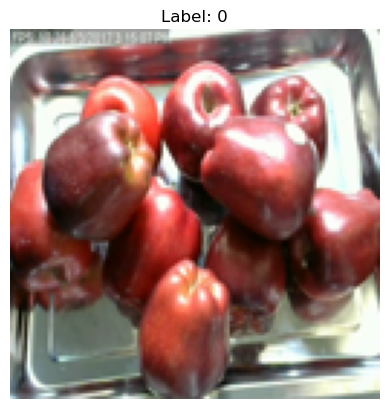

In [12]:
import matplotlib.pyplot as plt

# Function to display an image from the array
def display_image(image_array, label):
    plt.imshow(image_array)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Display the first image in the dataset
display_image(images[0], labels[0])

In [4]:
# Normalize the images
images = images / 255.0

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [6]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\Javier Alarcon\anaconda3\envs\dev\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.8320 - loss: 0.3778 - val_accuracy: 0.9219 - val_loss: 0.1791
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.9614 - loss: 0.0942 - val_accuracy: 0.9947 - val_loss: 0.0219
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9895 - loss: 0.0328 - val_accuracy: 0.9633 - val_loss: 0.0974
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9812 - loss: 0.0513 - val_accuracy: 0.9907 - val_loss: 0.0314
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9930 - loss: 0.0196 - val_accuracy: 0.9953 - val_loss: 0.0183
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9953 - val_loss: 0.0133
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9985 - loss: 0.0031 - val_accuracy: 0.9967 - val_loss: 0.0158
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9999 - loss: 0

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

47/47 - 1s - 30ms/step - accuracy: 0.9693 - loss: 0.2248
Test accuracy: 0.969292402267456


In [9]:
# Predict on test data
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [10]:
# Print some of the predictions to see how the model performs
for i in range(10):
    print(f'Actual: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted: {predicted_labels[i]}')

Actual: Banana, Predicted: Banana
Actual: Banana, Predicted: Apple
Actual: Apple, Predicted: Apple
Actual: Banana, Predicted: Banana
Actual: Apple, Predicted: Apple
Actual: Apple, Predicted: Apple
Actual: Banana, Predicted: Banana
Actual: Banana, Predicted: Banana
Actual: Apple, Predicted: Apple
Actual: Banana, Predicted: Banana
